### Noise-based training of a CTRNN-SDI model using Ornstein-Uhlenbeck adaptation

In [201]:
import jax
import jax.numpy as jnp
import jax.random as jr
import diffrax as dfx
import equinox as eqx
from neuromorphic_intelligence.oua import OUAModel
from neuromorphic_intelligence.models import HarmonicOscillator, CTRNN, CoupledSystem
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation

# set colormap
cmap = plt.get_cmap("tab10")
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=cmap.colors)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

solver = dfx.GeneralShARK

Setup system

In [202]:
# coupled system

agent = CTRNN(num_inputs=2, num_neurons=2, num_outputs=1, noise_scale=0.01)
env = HarmonicOscillator(mass=1.0, damping_factor=0.1, noise_scale=0.1)
coupled_system = CoupledSystem(agent=agent, env=env)

def reward(t, x, args):
    (agent_state, env_state), agent_params, agent_means, avg_reward = x
    position, velocity = env_state
    tau, A, bias, B, C = agent_params
    u = jax.nn.tanh(jnp.squeeze(C @ agent_state))
    # return -0.9 * jnp.linalg.norm(position)**2 - 0.1 * jnp.linalg.norm(u)**2 
    return - jnp.linalg.norm(position)**2 - jnp.linalg.norm(u)**2 
    # return -0.9 * jnp.linalg.norm(position)**2 - 0.1 *jnp.linalg.norm(velocity)**2 

def custom_output(t, x, args):
    return x, args['reward'](t, x, args)

args = {'reward': reward}

# simulation parameters
# key = jr.PRNGKey(42)
# t0=0
# t1=300
# dt0=0.1

# model parameters
# param_rate = 2.0
# noise_rate = 0.1
# mean_rate = 5.0
# reward_rate = 2.0

key = jr.PRNGKey(46)
t0=0
t1=2000 # 300
dt0=0.1

# model parameters
param_rate = 3.0
noise_rate = 0.15
mean_rate = 15.0
reward_rate = 3.0

# param_rate = 5.0 # 5 or 10 keep theta closer to mean
# noise_rate = 0.1
# mean_rate = 4.0
# reward_rate = 3.0

# param_rate = 1.0
# noise_rate = 1e-3
# mean_rate = 50.0
# reward_rate = 2.0


No learning

In [203]:
system = OUAModel(model=coupled_system, param_rate=param_rate, noise_rate=0.0, mean_rate=mean_rate, reward_rate=reward_rate)

sol = dfx.diffeqsolve(system.terms(key), solver(), args=args, t0=t0, t1=t1, dt0=dt0, y0=system.initial, saveat=dfx.SaveAt(steps=True, fn=custom_output), adjoint=dfx.DirectAdjoint(), max_steps=int(1e6))

x, reward2 = sol.ys
(agent_state2, env_state2), agent_params2, agent_means2, avg_reward2 = x

Learning

In [204]:
system = OUAModel(model=coupled_system, param_rate=param_rate, noise_rate=noise_rate, mean_rate=mean_rate, reward_rate=reward_rate)

sol = dfx.diffeqsolve(system.terms(key), solver(), args=args, t0=t0, t1=t1, dt0=dt0, y0=system.initial, saveat=dfx.SaveAt(steps=True, fn=custom_output), adjoint=dfx.DirectAdjoint(), max_steps=int(1e6))

x, reward = sol.ys
(agent_state, env_state), agent_params, agent_means, avg_reward = x


Multiple runs to get error bars on the rewards

In [205]:
ts_learning = []
ts_nolearning = []
return_learning = []
return_nolearning = []
N=10
for i in range(N):

    # learning
    system = OUAModel(model=coupled_system, param_rate=param_rate, noise_rate=noise_rate, mean_rate=mean_rate, reward_rate=reward_rate)
    sol = dfx.diffeqsolve(system.terms(jr.PRNGKey(42+4*i)), solver(), args=args, t0=t0, t1=t1, dt0=dt0, y0=system.initial, saveat=dfx.SaveAt(steps=True, fn=custom_output), adjoint=dfx.DirectAdjoint(), max_steps=int(1e6))    
    _, reward_ = sol.ys
    ts_learning.append(sol.ts)
    return_learning.append(jnp.cumsum(reward_))

    # no learning
    system = OUAModel(model=coupled_system, param_rate=param_rate, noise_rate=0.0, mean_rate=mean_rate, reward_rate=reward_rate)
    sol = dfx.diffeqsolve(system.terms(jr.PRNGKey(42+4*i)), solver(), args=args, t0=t0, t1=t1, dt0=dt0, y0=system.initial, saveat=dfx.SaveAt(steps=True, fn=custom_output), adjoint=dfx.DirectAdjoint(), max_steps=int(1e6))    
    _, reward_ = sol.ys
    ts_nolearning.append(sol.ts)
    return_nolearning.append(jnp.cumsum(reward_))
    
return_learning = jnp.array(return_learning)
means_learning = return_learning.mean(axis=0)
stds_learning = return_learning.std(axis=0)
# stats for interquartile range
q1_learning = jnp.nanpercentile(return_learning, 25, axis=0)
q3_learning = jnp.nanpercentile(return_learning, 75, axis=0)
median_learning = jnp.nanmedian(return_learning, axis=0)

return_nolearning = jnp.array(return_nolearning)
means_nolearning = return_nolearning.mean(axis=0)
stds_nolearning = return_nolearning.std(axis=0)
q1_nolearning = jnp.nanpercentile(return_nolearning, 25, axis=0)
q3_nolearning = jnp.nanpercentile(return_nolearning, 75, axis=0)
median_nolearning = jnp.nanmedian(return_nolearning, axis=0)

Complete figure

number of NaNs in learning returns: 4


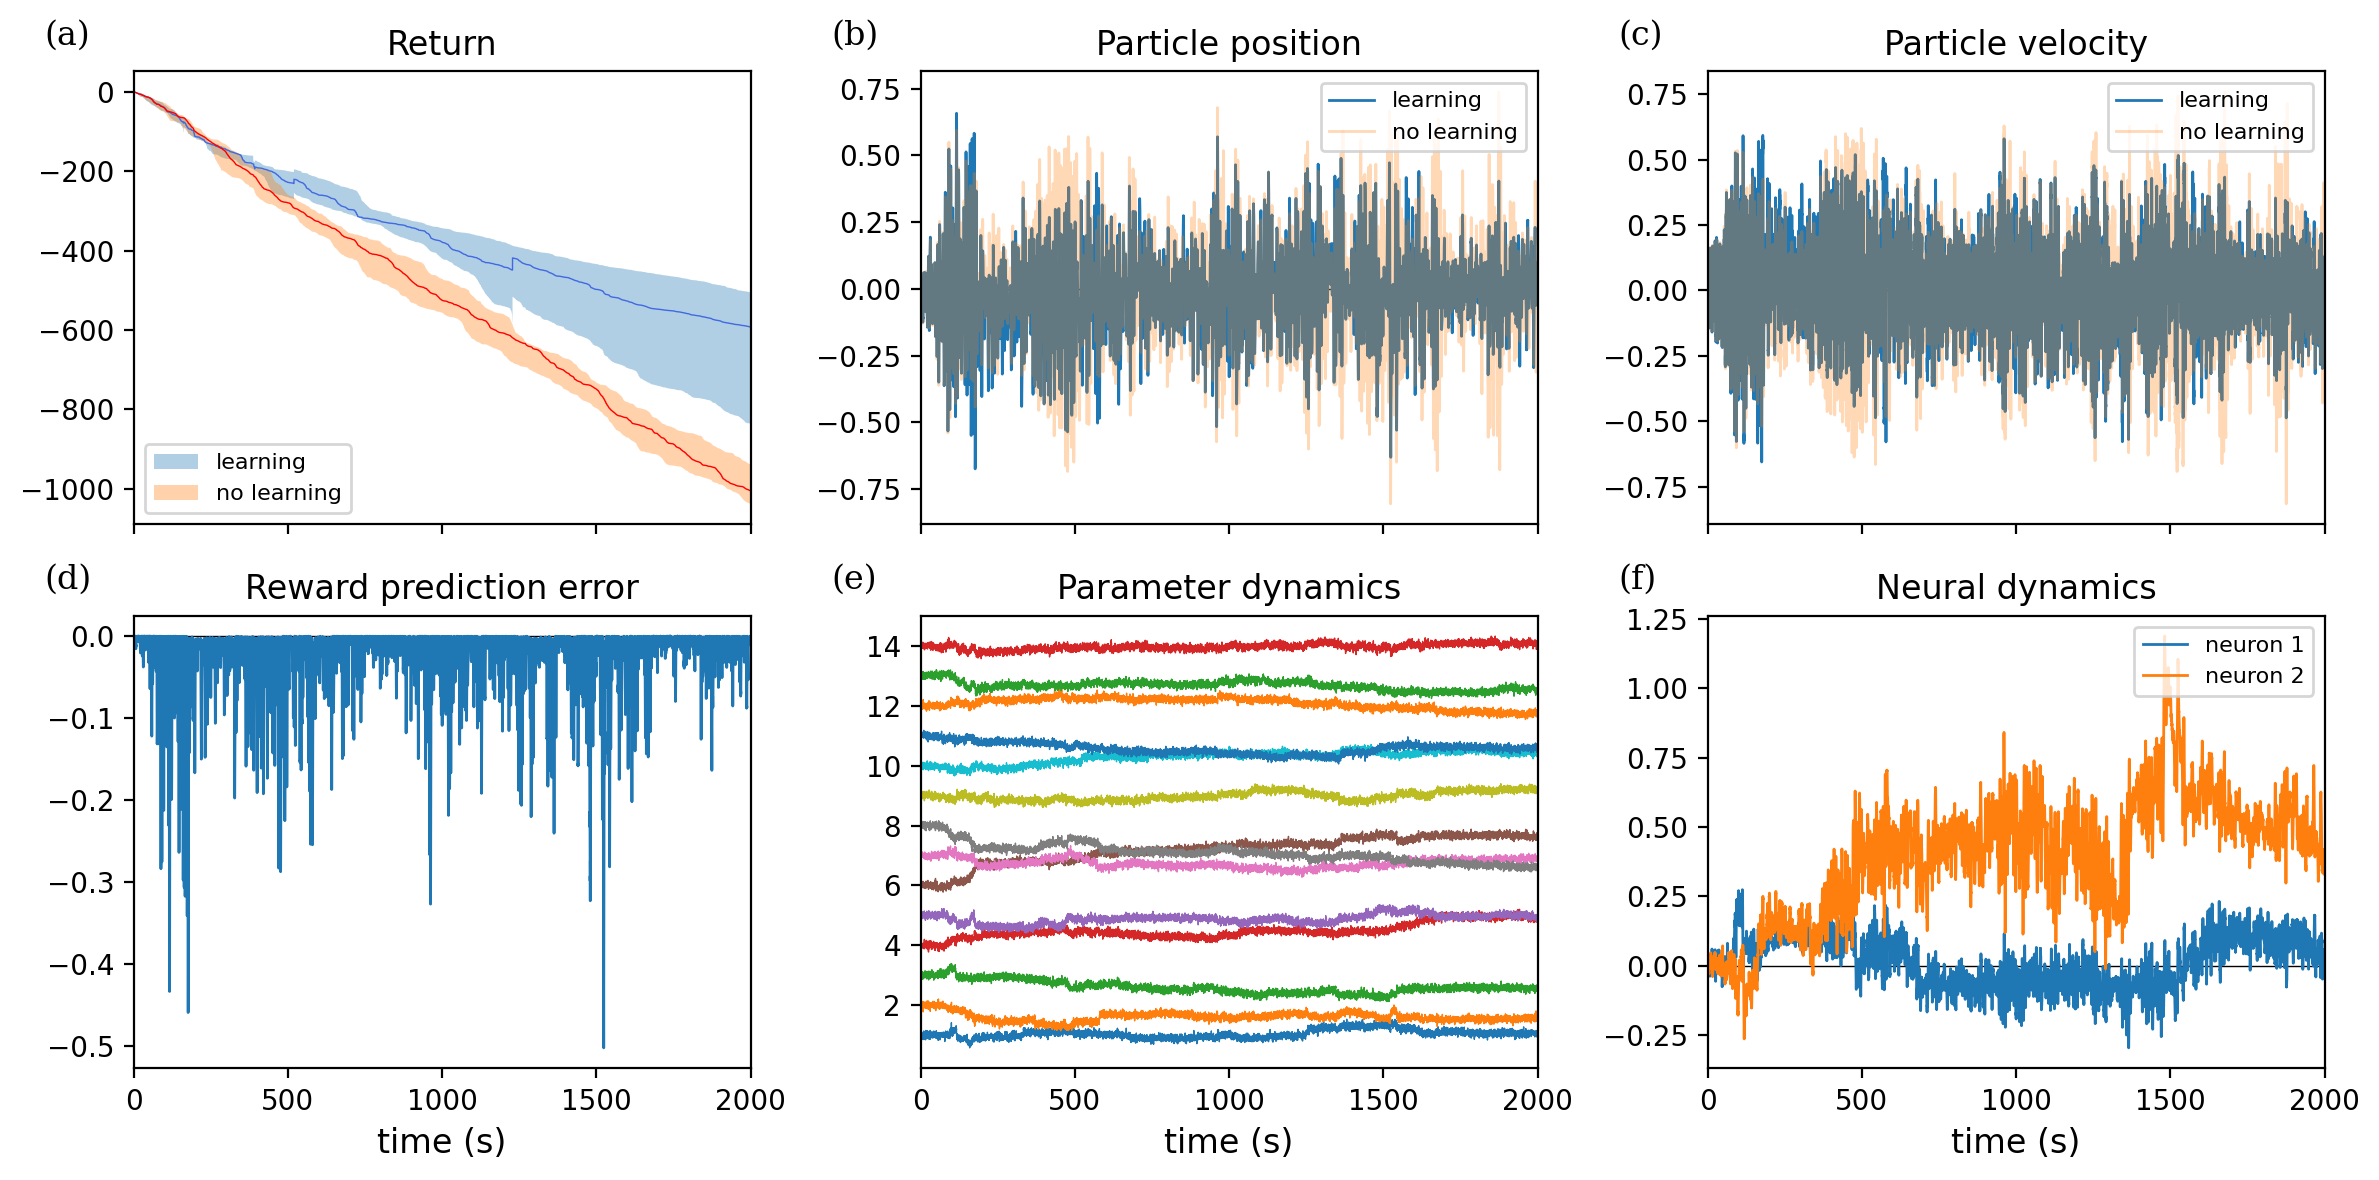

In [206]:
import seaborn as sns

with sns.color_palette("tab10"):

    fig, ax = plt.subplots(2,3, figsize=(12,6), sharex=True)
    fig.align_xlabels(ax)
    fig.align_ylabels(ax)

     # plot standard deviation and additional curves
    # ax[0,2].fill_between(ts_learning[0], means_learning-stds_learning, means_learning+stds_learning, alpha=0.5)
    ax[0,0].fill_between(ts_learning[0], q1_learning, q3_learning, alpha=0.35, label='learning')
    ax[0,0].plot(ts_learning[0], median_learning, color='royalblue', lw=0.5)
    # for i in range(N):
    #     if i == 0:
    #         ax[0,0].plot(ts_learning[i], return_learning[i], color=cmap(0), alpha=1, lw=1, label='learning')
    #     else:
    #         ax[0,0].plot(ts_learning[i], return_learning[i], color=cmap(0), alpha=1, lw=1)

    # ax[0,0].fill_between(ts_nolearning[0], means_nolearning-stds_nolearning, means_nolearning+stds_nolearning, alpha=0.5)
    ax[0,0].fill_between(ts_nolearning[0], q1_nolearning, q3_nolearning, alpha=0.35, label='no learning')
    ax[0,0].plot(ts_nolearning[0], median_nolearning, color='red', lw=0.5)
    # for i in range(N):
    #     if i == 0:
    #         ax[0,0].plot(ts_learning[i], return_nolearning[i], color=cmap(1), alpha=1, lw=1, label='no learning')
    #     else:
    #         ax[0,0].plot(ts_nolearning[i], return_nolearning[i], color=cmap(1), alpha=1, lw=1)            

    ax[0,0].legend(loc='lower left')

    # plot smooth histogram of returns
    # import numpy as np
    # from scipy.ndimage import gaussian_filter1d
    # returns = jnp.array(return_learning)
    # returns = jnp.min(returns, axis=1)
    # bins = jnp.linspace(jnp.min(returns), jnp.max(returns), num=50)
    # hist, bin_edges = jnp.histogram(returns, bins=bins, density=True)
    # hist = gaussian_filter1d(hist, sigma=1)
    # ax[0,2].plot(bin_edges[:-1], hist, color='black', lw=2)

    # ax[0,0].set_ylim([-5000, 0])

    ax[0,0].set_title('Return');
    ax[0,0].text(0.0, 1.0, '(a)', transform=(
        ax[0,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')

    ax[0,1].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    ax[0,1].plot(sol.ts, env_state[:,0],label='learning', lw=1.0)
    ax[0,1].plot(sol.ts, env_state2[:,0],label='no learning', lw=1.0, alpha=0.3)
    ax[0,1].legend(loc='upper right')
    ax[0,1].set_title('Particle position');
    ax[0,1].text(0.0, 1.0, '(b)', transform=(
        ax[0,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')

    ax[0,2].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    ax[0,2].plot(sol.ts, env_state[:,1],label='learning',lw=1.0);
    ax[0,2].plot(sol.ts, env_state2[:,1],label='no learning', lw=1.0, alpha=0.3);
    ax[0,2].legend(loc='upper right')
    ax[0,2].set_title('Particle velocity');
    ax[0,2].text(0.0, 1.0, '(c)', transform=(
        ax[0,2].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')
                
    ax[1,0].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    ax[1,0].plot(sol.ts, reward, lw=1.0);
    # ax[1,2].plot(sol.ts, avg_reward, lw=1.0);
    # ax[1,2].plot(sol.ts, reward - avg_reward, lw=1.0);
    # # ax[1,2].legend(['true reward', 'estimated reward', 'reward prediction error'], loc='lower right')
    # ax[1,2].set_title('Instantaneous reward');
    ax[1,0].set_title('Reward prediction error');
    ax[1,0].text(0.0, 1.0, '(d)', transform=(
        ax[1,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')

    # ax[1,1].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')

    # collect all parameters
    params = jnp.vstack(jax.tree.map(lambda x: jnp.reshape(x, (len(sol.ts), -1)).T, agent_params))
    for i in range(params.shape[0]):
        ax[1,1].plot(sol.ts, 1 + i + params[i], lw=0.5);
    
    ax[1,1].set_yticks(jnp.arange(2, params.shape[0]+1, 2))
    # for i, p in enumerate(agent_means):
    #     ax[1,1].plot(sol.ts, i + jnp.reshape(p, shape), lw=0.5, color='k');
    # for i, p in enumerate(agent_params):
    #     ax[1,1].plot(sol.ts, i + jnp.reshape(p, shape), lw=0.5, alpha=0.5);
    ax[1,1].set_title('Parameter dynamics');
    ax[1,1].text(0.0, 1.0, '(e)', transform=(
        ax[1,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')
    
    ax[1,2].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    ax[1,2].plot(sol.ts, agent_state, lw=1.0);0
    ax[1,2].set_title('Neural dynamics');
    ax[1,2].legend(['neuron 1', 'neuron 2'], loc='upper right')
    ax[1,2].text(0.0, 1.0, '(f)', transform=(
        ax[1,2].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')
  

    for i in range(3):
        ax[1,i].set_xlabel('time (s)')
    
    for i in range(2):
        for j in range(3):
            ax[i,j].margins(x=0)

    plt.tight_layout()

print('number of NaNs in learning returns:', jnp.sum(jnp.any(jnp.isnan(return_learning), axis=1)))

plt.savefig('../figures/noise_based_learning_sho.pdf', format='pdf')